# Librerie

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers, datasets, optimizers, preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import shutil

# Fuzioni generali

In [4]:
def make_path_img(path):
    try:
        os.mkdir(path)
    except FileExistsError:
        shutil.rmtree(path)
        os.mkdir(path)

def create_dataset(path, dim1, dim2):
    import glob
    from PIL import Image
    folder = [x[0] for x in os.walk(path)][1:]
    folder.sort()
    label = []
    image = []
    classes = 0
    for path in folder:
        n = 0
        for filename in glob.glob(path+'/*.jpg'): 
            im=Image.open(filename)
            image.append(np.array(im.resize((dim1, dim2), Image.ANTIALIAS)))
            n += 1
        for i in range(n):
            label.append(classes)
        classes += 1
    return np.array(image), np.array(label)

def create_gif(path):
    anim_file = 'dcgan.gif'
    import imageio
    import glob
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('gen_img/*.png')
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
    shutil.rmtree(path)
    
def plot_generated_images(noise, epoch, generator, input_shape, n_classes):
    generated_images = generator.predict(noise)
    generated_images = (generated_images.reshape(n_classes, input_shape[0], input_shape[1]) + 1) / 2.0
    plt.figure(figsize=(6, 3))
    for i in range(generated_images.shape[0]):
        plt.subplot(2, 5, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gen_img/gan_generated_image_epoch_%d.png' % epoch)
    plt.show()

# Generatore e discriminatore

In [5]:
def generator(noise_dim, n_classes):
    #etichetta in input
    input_label = layers.Input(shape=(1,))
    #embedding dell'input
    i_l = layers.Embedding(n_classes, 50)(input_label)
    #ingrandisco il layer input fino a farlo diventare grande come l'immagine
    i_l = layers.Dense(7 * 7)(i_l)
    i_l = layers.Reshape((7, 7, 1))(i_l)
    #rumore in input
    input_noise = layers.Input(shape=(noise_dim,))
    gen = layers.Dense(7 *7 * 256, use_bias=False)(input_noise)
    gen = layers.BatchNormalization()(gen)
    gen = layers.ReLU()(gen)
    gen = layers.Reshape((7, 7, 256))(gen)
    #concateno il rumore generato con l'etichetta
    merge = layers.Concatenate()([gen, i_l])
    #convoluzioni
    gen = layers.Conv2DTranspose(128, 4, strides=1, padding='same', use_bias=False)(merge)
    gen = layers.BatchNormalization()(gen)
    gen = layers.ReLU()(gen)
    gen = layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False)(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.ReLU()(gen)
    gen = layers.Conv2DTranspose(32, 4, strides=2, padding='same', use_bias=False)(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.ReLU()(gen)
    output_layer = layers.Conv2D(1, 4, strides=1, padding='same', use_bias=False, activation='tanh')(gen)

    model = models.Model([input_noise, input_label], output_layer)
    
    return model

def discriminator(input_shape, n_classes):
    #etichetta in input
    input_label = layers.Input(shape=(1,))
    #embedding dell'input
    i_l = layers.Embedding(n_classes, 50)(input_label)
    #ingrandisco il layer input fino a farlo diventare grande come l'immagine
    i_l = layers.Dense(input_shape[0] * input_shape[1])(i_l)
    i_l = layers.Reshape((input_shape[0], input_shape[1], 1))(i_l)
    #immagine in input
    input_image = layers.Input(shape=input_shape)
    #concateno i livelli immagine e impunt embedded: (28,28,2)
    merge = layers.Concatenate()([input_image, i_l])
    #convoluzioni
    disc = layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(merge)
    disc = layers.LeakyReLU(0.2)(disc)
    disc = layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False)(disc)
    disc = layers.LeakyReLU(0.2)(disc)
    disc = layers.Conv2D(128, 3, strides=2, padding='same', use_bias=False)(disc)
    disc = layers.LeakyReLU(0.2)(disc)
    disc = layers.GlobalMaxPooling2D()(disc)
    disc = layers.Dropout(0.2)(disc)
    output_layer = layers.Dense(1, activation='sigmoid')(disc)
    
    model = models.Model([input_image, input_label], output_layer)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5),
                  metrics=['acc']
                  )
    return model

def gan_net(disc, gen, noise_dim):
    
    disc.trainable = False
    gen.trainable = True
    
    #prendo il rumore e le etichette input dal generatore
    gen_noise, gen_label = gen.input
    #prendo l'immagine output dal generatore
    gen_output = gen.output
    #connetto l'immagine output e le etichette input dal generatore e le passo come input al discriminatore
    gan_output = disc([gen_output, gen_label])
    #genero il modello della GAN: è principlamente il generatore seguito dal discriminatore
    gan = models.Model([gen_noise, gen_label], gan_output)
    
    gan.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5))
    return gan

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12544)        1254400     input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12544)        50176       dense_1[0][0]                    
_______________________________________________________________________________________

--------------- Epoch 2 ---------------
2 [D loss real: 0.690450, D loss fake: 0.694869] [G loss: 0.755009]


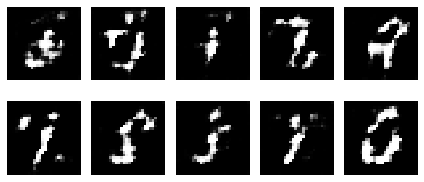

--------------- Epoch 3 ---------------
3 [D loss real: 0.715228, D loss fake: 0.700502] [G loss: 0.733518]


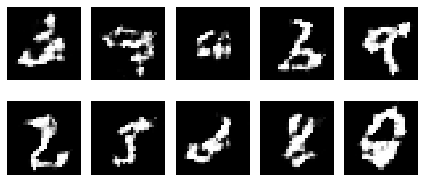

--------------- Epoch 4 ---------------
4 [D loss real: 0.707046, D loss fake: 0.698045] [G loss: 0.716806]


--------------- Epoch 5 ---------------
5 [D loss real: 0.681904, D loss fake: 0.692076] [G loss: 0.716863]


--------------- Epoch 6 ---------------
6 [D loss real: 0.680688, D loss fake: 0.653582] [G loss: 0.800626]


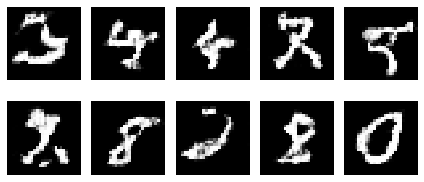

--------------- Epoch 7 ---------------
7 [D loss real: 0.684035, D loss fake: 0.671696] [G loss: 0.759675]


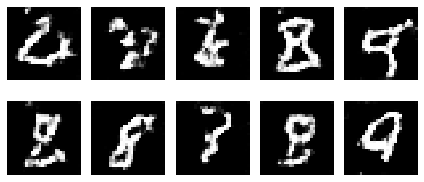

--------------- Epoch 8 ---------------
8 [D loss real: 0.698298, D loss fake: 0.695778] [G loss: 0.716944]


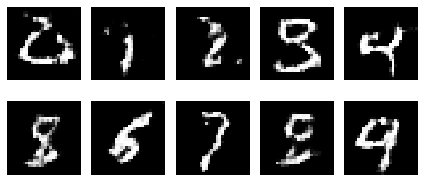

--------------- Epoch 9 ---------------
9 [D loss real: 0.698820, D loss fake: 0.717834] [G loss: 0.697221]


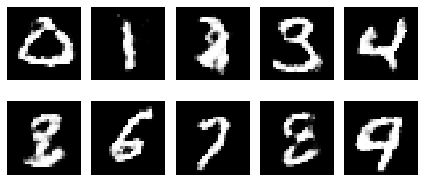

--------------- Epoch 10 ---------------
10 [D loss real: 0.680413, D loss fake: 0.703486] [G loss: 0.689125]


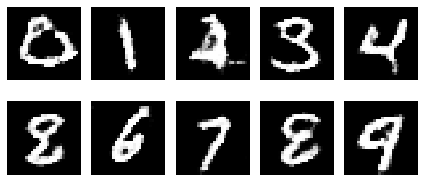

--------------- Epoch 11 ---------------
11 [D loss real: 0.687931, D loss fake: 0.711237] [G loss: 0.692532]


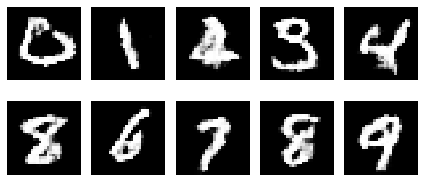

--------------- Epoch 12 ---------------
12 [D loss real: 0.673812, D loss fake: 0.706877] [G loss: 0.721346]


--------------- Epoch 13 ---------------
13 [D loss real: 0.682750, D loss fake: 0.704908] [G loss: 0.681222]


--------------- Epoch 14 ---------------
14 [D loss real: 0.686454, D loss fake: 0.711977] [G loss: 0.699693]


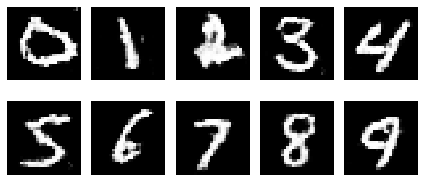

--------------- Epoch 15 ---------------
15 [D loss real: 0.714148, D loss fake: 0.674414] [G loss: 0.746828]


--------------- Epoch 16 ---------------
16 [D loss real: 0.677331, D loss fake: 0.706511] [G loss: 0.693349]


--------------- Epoch 17 ---------------
17 [D loss real: 0.718276, D loss fake: 0.660225] [G loss: 0.743957]


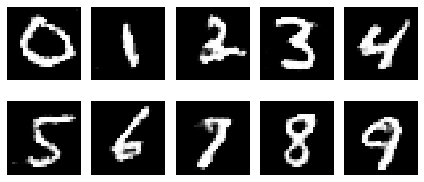

--------------- Epoch 18 ---------------
18 [D loss real: 0.695669, D loss fake: 0.690257] [G loss: 0.703106]


--------------- Epoch 19 ---------------
19 [D loss real: 0.693901, D loss fake: 0.696752] [G loss: 0.697191]


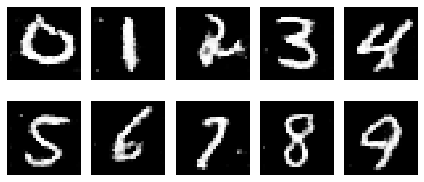

--------------- Epoch 20 ---------------
20 [D loss real: 0.699575, D loss fake: 0.689343] [G loss: 0.699579]


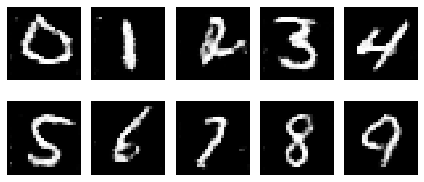

--------------- Epoch 21 ---------------
21 [D loss real: 0.692613, D loss fake: 0.693700] [G loss: 0.700073]


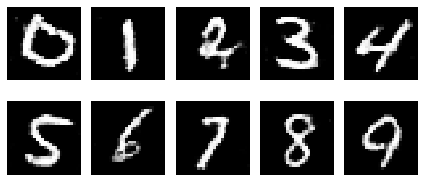

--------------- Epoch 22 ---------------
22 [D loss real: 0.696431, D loss fake: 0.686042] [G loss: 0.701982]


--------------- Epoch 23 ---------------
23 [D loss real: 0.698905, D loss fake: 0.693374] [G loss: 0.700990]


--------------- Epoch 24 ---------------
24 [D loss real: 0.696944, D loss fake: 0.691902] [G loss: 0.698364]


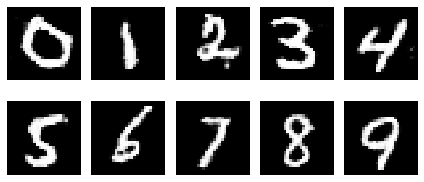

--------------- Epoch 25 ---------------
25 [D loss real: 0.692047, D loss fake: 0.693150] [G loss: 0.699232]


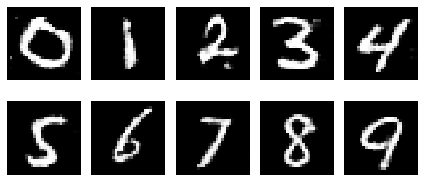

--------------- Epoch 26 ---------------
26 [D loss real: 0.692301, D loss fake: 0.687954] [G loss: 0.696929]


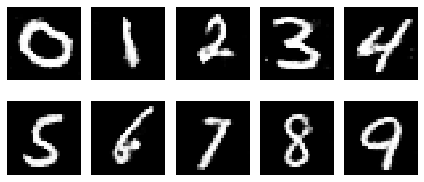

--------------- Epoch 27 ---------------
27 [D loss real: 0.689654, D loss fake: 0.691816] [G loss: 0.700336]


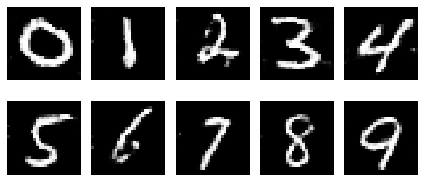

--------------- Epoch 28 ---------------
28 [D loss real: 0.685175, D loss fake: 0.688213] [G loss: 0.700041]


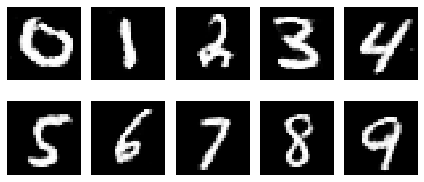

--------------- Epoch 29 ---------------
29 [D loss real: 0.689585, D loss fake: 0.700322] [G loss: 0.696306]


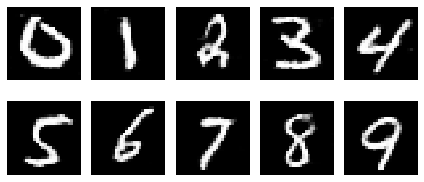

--------------- Epoch 30 ---------------
30 [D loss real: 0.693695, D loss fake: 0.688242] [G loss: 0.702416]


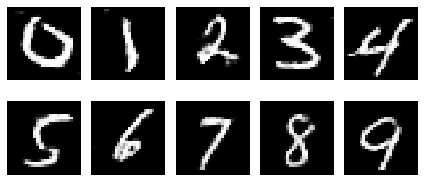

--------------- Epoch 31 ---------------
31 [D loss real: 0.687918, D loss fake: 0.692327] [G loss: 0.698868]


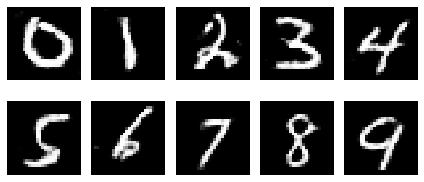

--------------- Epoch 32 ---------------
32 [D loss real: 0.685721, D loss fake: 0.692936] [G loss: 0.692606]


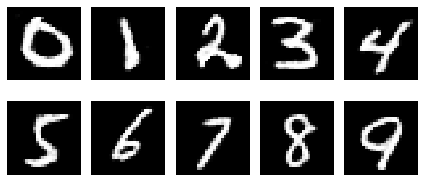

--------------- Epoch 33 ---------------
33 [D loss real: 0.686527, D loss fake: 0.690087] [G loss: 0.692296]


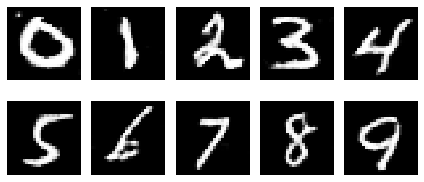

--------------- Epoch 34 ---------------
34 [D loss real: 0.693617, D loss fake: 0.693375] [G loss: 0.692822]


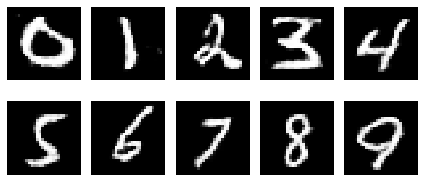

--------------- Epoch 35 ---------------
35 [D loss real: 0.694265, D loss fake: 0.694928] [G loss: 0.699120]


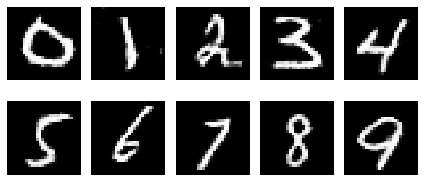

--------------- Epoch 36 ---------------
36 [D loss real: 0.692160, D loss fake: 0.698896] [G loss: 0.695708]


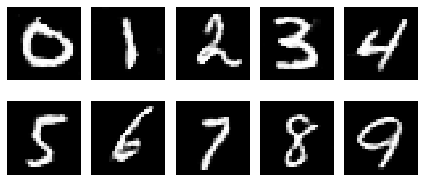

--------------- Epoch 37 ---------------
37 [D loss real: 0.686767, D loss fake: 0.693715] [G loss: 0.697550]


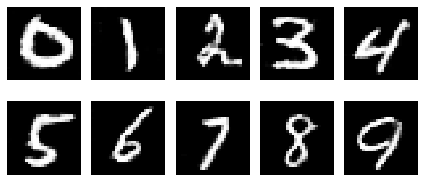

--------------- Epoch 38 ---------------
38 [D loss real: 0.682691, D loss fake: 0.694515] [G loss: 0.702545]


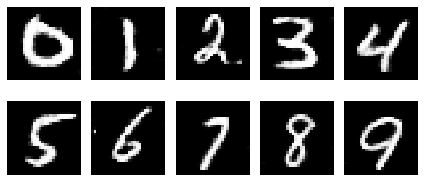

--------------- Epoch 39 ---------------
39 [D loss real: 0.688818, D loss fake: 0.691293] [G loss: 0.712150]


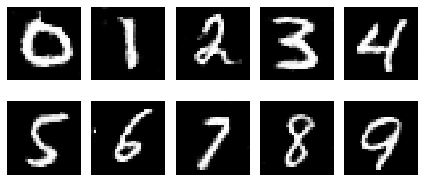

--------------- Epoch 40 ---------------
40 [D loss real: 0.690304, D loss fake: 0.695812] [G loss: 0.698710]


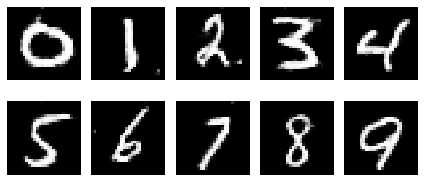

--------------- Epoch 41 ---------------
41 [D loss real: 0.686520, D loss fake: 0.691360] [G loss: 0.699108]


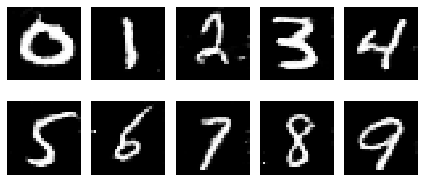

--------------- Epoch 42 ---------------
42 [D loss real: 0.687316, D loss fake: 0.687492] [G loss: 0.695675]


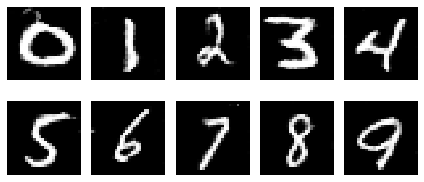

--------------- Epoch 43 ---------------
43 [D loss real: 0.689851, D loss fake: 0.686408] [G loss: 0.706470]


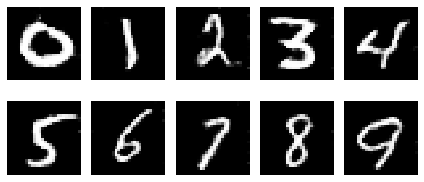

--------------- Epoch 44 ---------------
44 [D loss real: 0.686999, D loss fake: 0.692217] [G loss: 0.697648]


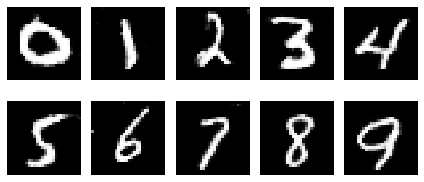

--------------- Epoch 45 ---------------
45 [D loss real: 0.682177, D loss fake: 0.690012] [G loss: 0.701495]


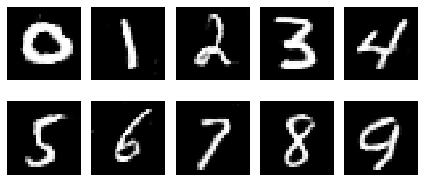

--------------- Epoch 46 ---------------
46 [D loss real: 0.692983, D loss fake: 0.698982] [G loss: 0.701295]


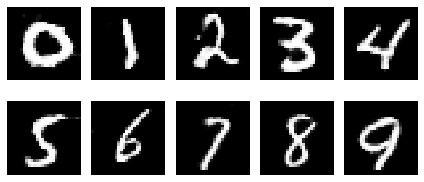

--------------- Epoch 47 ---------------
47 [D loss real: 0.690751, D loss fake: 0.687144] [G loss: 0.703926]


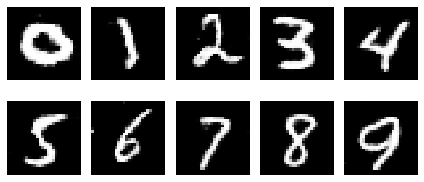

--------------- Epoch 48 ---------------
48 [D loss real: 0.690672, D loss fake: 0.695016] [G loss: 0.707201]


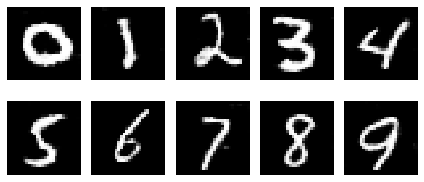

--------------- Epoch 49 ---------------
49 [D loss real: 0.684339, D loss fake: 0.689738] [G loss: 0.700288]


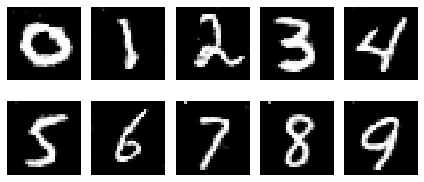

--------------- Epoch 50 ---------------
50 [D loss real: 0.678652, D loss fake: 0.704721] [G loss: 0.692539]


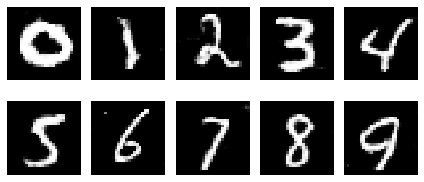

--------------- Epoch 51 ---------------
51 [D loss real: 0.684602, D loss fake: 0.697614] [G loss: 0.701392]


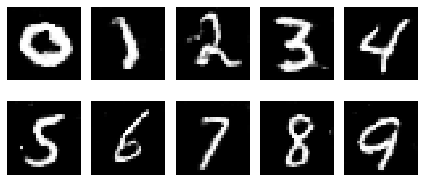

--------------- Epoch 52 ---------------
52 [D loss real: 0.688852, D loss fake: 0.686467] [G loss: 0.691968]


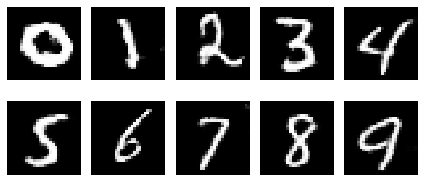

--------------- Epoch 53 ---------------
53 [D loss real: 0.694465, D loss fake: 0.689306] [G loss: 0.702469]


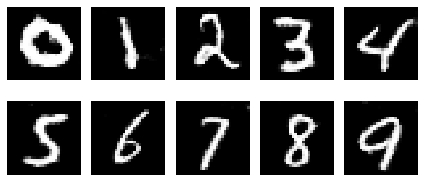

--------------- Epoch 54 ---------------
54 [D loss real: 0.697430, D loss fake: 0.689111] [G loss: 0.700094]


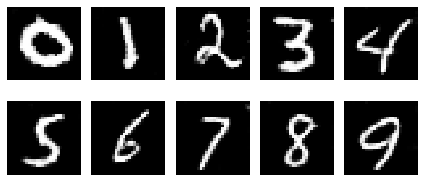

--------------- Epoch 55 ---------------
55 [D loss real: 0.690046, D loss fake: 0.687968] [G loss: 0.700809]


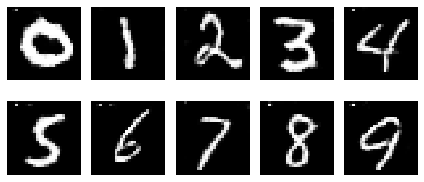

--------------- Epoch 56 ---------------
56 [D loss real: 0.683923, D loss fake: 0.698247] [G loss: 0.699642]


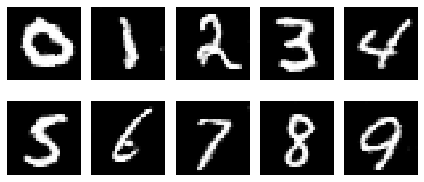

--------------- Epoch 57 ---------------
57 [D loss real: 0.690928, D loss fake: 0.691869] [G loss: 0.710632]


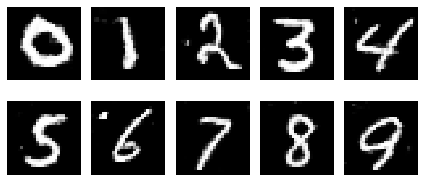

--------------- Epoch 58 ---------------
58 [D loss real: 0.690456, D loss fake: 0.674804] [G loss: 0.703889]


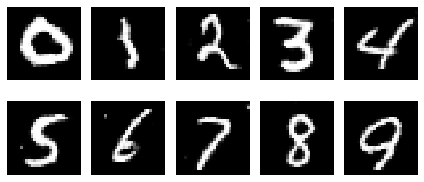

--------------- Epoch 59 ---------------
59 [D loss real: 0.692674, D loss fake: 0.693081] [G loss: 0.707566]


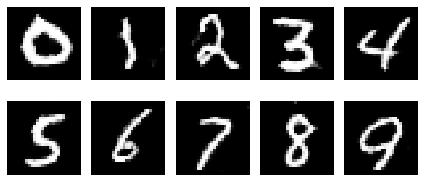

--------------- Epoch 60 ---------------
60 [D loss real: 0.689223, D loss fake: 0.695731] [G loss: 0.702370]


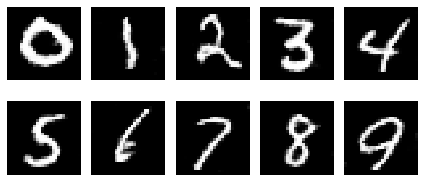

--------------- Epoch 61 ---------------
61 [D loss real: 0.689437, D loss fake: 0.692062] [G loss: 0.709443]


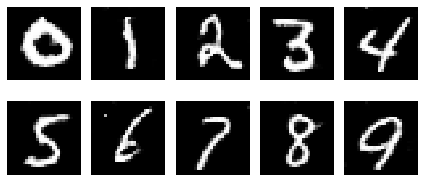

--------------- Epoch 62 ---------------
62 [D loss real: 0.686486, D loss fake: 0.683573] [G loss: 0.702705]


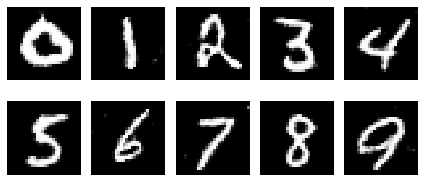

--------------- Epoch 63 ---------------
63 [D loss real: 0.694052, D loss fake: 0.698231] [G loss: 0.700163]


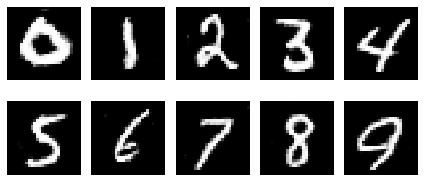

--------------- Epoch 64 ---------------
64 [D loss real: 0.686679, D loss fake: 0.696983] [G loss: 0.697798]


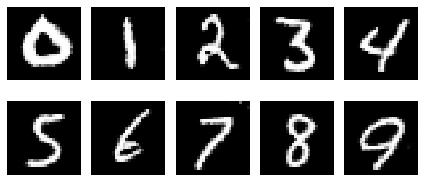

--------------- Epoch 65 ---------------
65 [D loss real: 0.683075, D loss fake: 0.694667] [G loss: 0.715487]


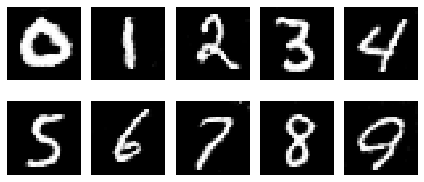

--------------- Epoch 66 ---------------
66 [D loss real: 0.697628, D loss fake: 0.697126] [G loss: 0.708289]


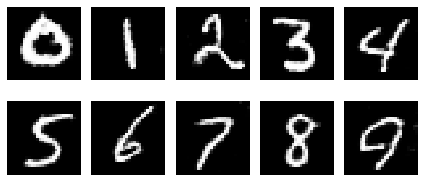

--------------- Epoch 67 ---------------
67 [D loss real: 0.686731, D loss fake: 0.682051] [G loss: 0.704571]


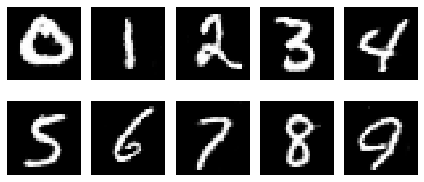

--------------- Epoch 68 ---------------
68 [D loss real: 0.693041, D loss fake: 0.698637] [G loss: 0.714739]


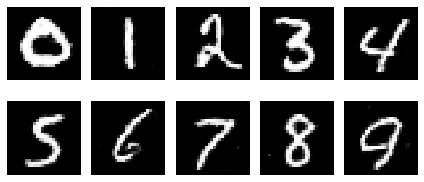

--------------- Epoch 69 ---------------
69 [D loss real: 0.692559, D loss fake: 0.693837] [G loss: 0.699999]


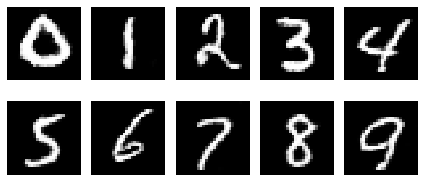

--------------- Epoch 70 ---------------
70 [D loss real: 0.685747, D loss fake: 0.693389] [G loss: 0.697151]


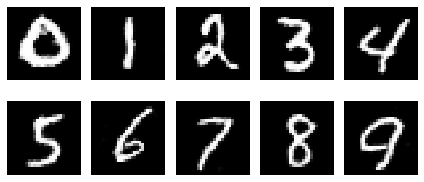

--------------- Epoch 71 ---------------
71 [D loss real: 0.684682, D loss fake: 0.695247] [G loss: 0.705849]


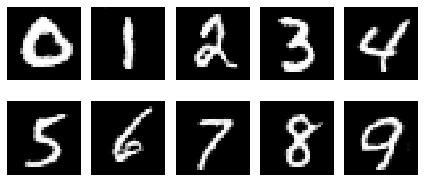

--------------- Epoch 72 ---------------
72 [D loss real: 0.683528, D loss fake: 0.693603] [G loss: 0.705974]


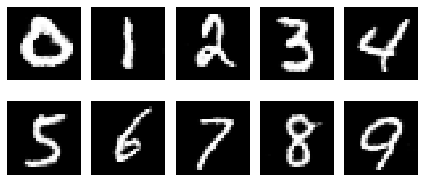

--------------- Epoch 73 ---------------
73 [D loss real: 0.683953, D loss fake: 0.688391] [G loss: 0.702579]


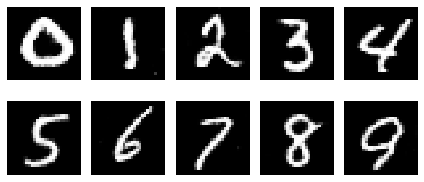

--------------- Epoch 74 ---------------
74 [D loss real: 0.685635, D loss fake: 0.690023] [G loss: 0.703441]


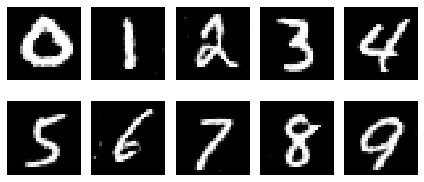

--------------- Epoch 75 ---------------
75 [D loss real: 0.700894, D loss fake: 0.684275] [G loss: 0.709348]


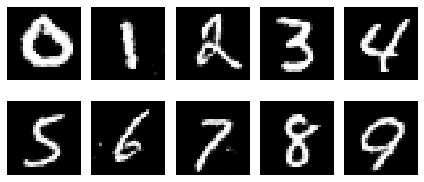

--------------- Epoch 76 ---------------
76 [D loss real: 0.682542, D loss fake: 0.688333] [G loss: 0.704001]


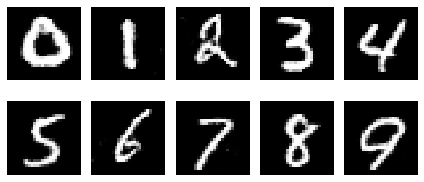

--------------- Epoch 77 ---------------
77 [D loss real: 0.672853, D loss fake: 0.697019] [G loss: 0.699706]


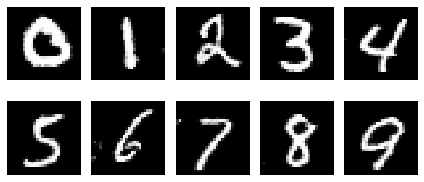

--------------- Epoch 78 ---------------
78 [D loss real: 0.697365, D loss fake: 0.696889] [G loss: 0.696205]


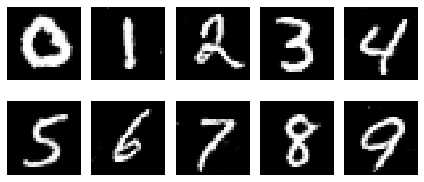

--------------- Epoch 79 ---------------
79 [D loss real: 0.686911, D loss fake: 0.692419] [G loss: 0.714551]


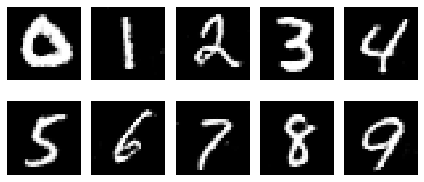

--------------- Epoch 80 ---------------
80 [D loss real: 0.682683, D loss fake: 0.698136] [G loss: 0.706409]


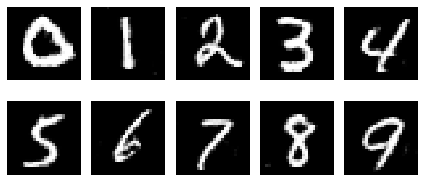

--------------- Epoch 81 ---------------
81 [D loss real: 0.680266, D loss fake: 0.693675] [G loss: 0.698554]


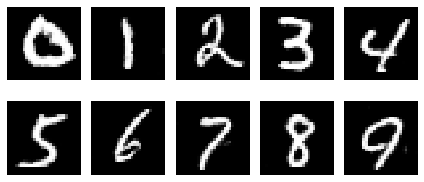

--------------- Epoch 82 ---------------
82 [D loss real: 0.690356, D loss fake: 0.701005] [G loss: 0.714839]


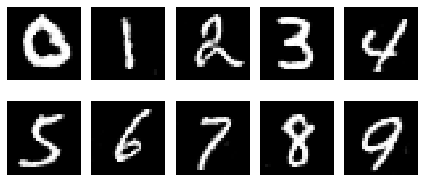

--------------- Epoch 83 ---------------
83 [D loss real: 0.679057, D loss fake: 0.700330] [G loss: 0.710298]


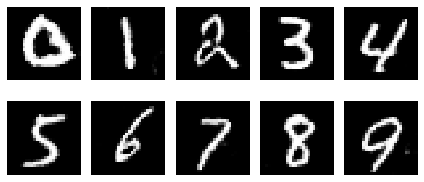

--------------- Epoch 84 ---------------
84 [D loss real: 0.701687, D loss fake: 0.687829] [G loss: 0.704277]


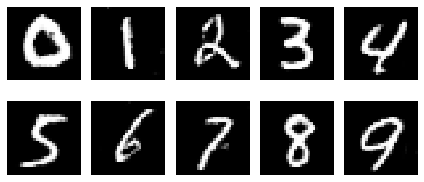

--------------- Epoch 85 ---------------
85 [D loss real: 0.687695, D loss fake: 0.703738] [G loss: 0.700071]


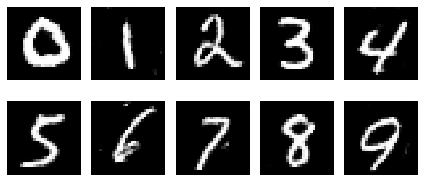

--------------- Epoch 86 ---------------
86 [D loss real: 0.676328, D loss fake: 0.687124] [G loss: 0.712719]


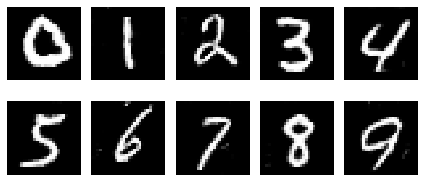

--------------- Epoch 87 ---------------
87 [D loss real: 0.688854, D loss fake: 0.693608] [G loss: 0.705007]


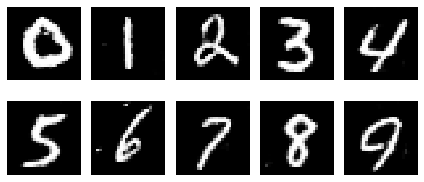

--------------- Epoch 88 ---------------
88 [D loss real: 0.680762, D loss fake: 0.681823] [G loss: 0.711413]


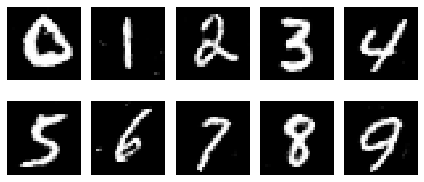

--------------- Epoch 89 ---------------
89 [D loss real: 0.682110, D loss fake: 0.682053] [G loss: 0.714405]


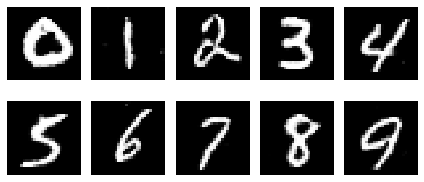

--------------- Epoch 90 ---------------
90 [D loss real: 0.679530, D loss fake: 0.694526] [G loss: 0.716659]


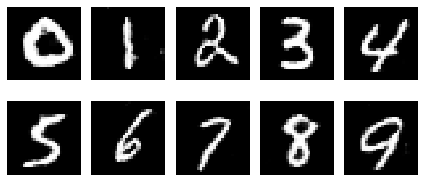

--------------- Epoch 91 ---------------
91 [D loss real: 0.698864, D loss fake: 0.702627] [G loss: 0.729112]


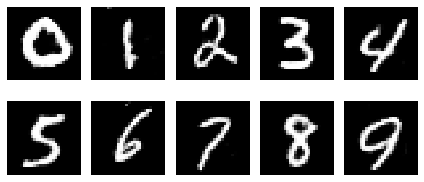

--------------- Epoch 92 ---------------
92 [D loss real: 0.686907, D loss fake: 0.685735] [G loss: 0.714140]


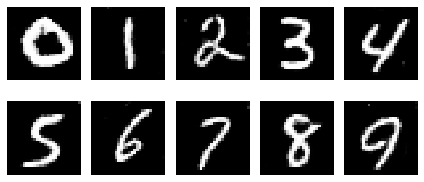

--------------- Epoch 93 ---------------
93 [D loss real: 0.681037, D loss fake: 0.689296] [G loss: 0.701354]


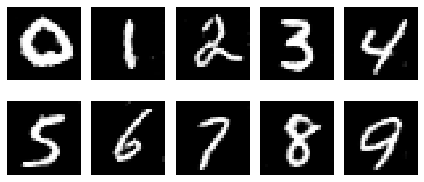

--------------- Epoch 94 ---------------
94 [D loss real: 0.684741, D loss fake: 0.686926] [G loss: 0.714662]


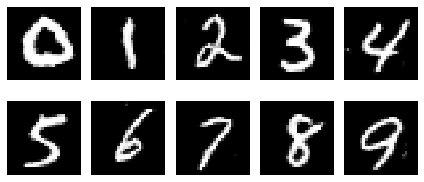

--------------- Epoch 95 ---------------
95 [D loss real: 0.684774, D loss fake: 0.670364] [G loss: 0.715901]


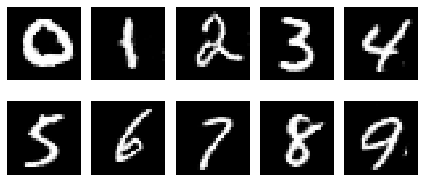

--------------- Epoch 96 ---------------
96 [D loss real: 0.687420, D loss fake: 0.684494] [G loss: 0.735906]


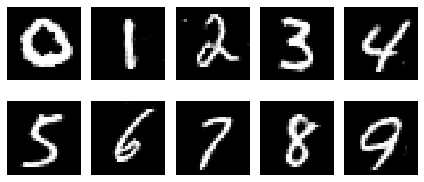

--------------- Epoch 97 ---------------
97 [D loss real: 0.692761, D loss fake: 0.686164] [G loss: 0.731922]


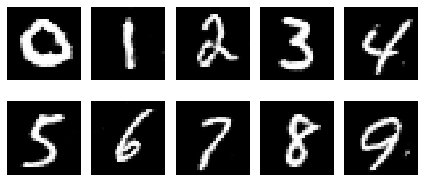

--------------- Epoch 98 ---------------
98 [D loss real: 0.694170, D loss fake: 0.680952] [G loss: 0.708928]


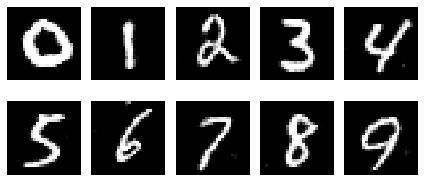

--------------- Epoch 99 ---------------
99 [D loss real: 0.689615, D loss fake: 0.679315] [G loss: 0.720095]


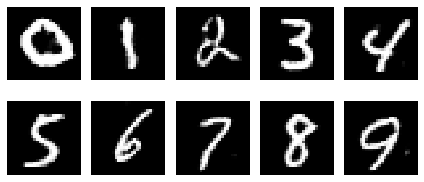

--------------- Epoch 100 ---------------
100 [D loss real: 0.685345, D loss fake: 0.703489] [G loss: 0.715231]


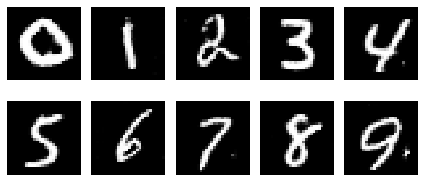

In [6]:
np.random.seed(0)

#dimensione immagine nelle reti
input_shape = (28, 28, 1)
#numero di classi
n_classes = 10

#dimensione rumore
noise_dim = 100

#creo generatore, discriminatore e GAN
gen = generator(noise_dim, n_classes)
gen.trainable = False
gen.summary()

disc = discriminator(input_shape, n_classes)
gen.trainable = False
disc.summary()

gan = gan_net(disc, gen, noise_dim)
gan.summary()

#importo il dataset: create_dataset lo da da una directory sul pc
(X_train, y_train), (_, _) = datasets.mnist.load_data()
#X_train, y_train = create_dataset('', 128, 128)

X_train = (X_train.reshape(-1, input_shape[0], input_shape[1], input_shape[2]).astype('float32') - 127.5) / 127.5

image_gen_train = preprocessing.image.ImageDataGenerator()

#directory per le immagini generate
path = 'gen_img'
make_path_img(path)

#esempi da stampare durante il training
noise_plot = np.random.normal(0, 1, size=[n_classes, noise_dim])
label_plot = np.arange(n_classes)

epochs = 100
#tqdm._instances.clear()
for e in range(1, epochs+1):
    
    print('-'*15, 'Epoch %d' % e, '-'*15)
    
    #generatore di immagini
    train = image_gen_train.flow(X_train, y_train, shuffle = True, batch_size = 128)

    #for i in tqdm(range(len(train))):
    for i in range(len(train)):
        
        #gestisco le immagini nel batch
        image_batch = train[i]
        image = image_batch[0]
        label = image_batch[1]
        batch_size = image.shape[0]
        
        #genero batch di rumore e batch con immagini
        noise = np.random.normal(0, 1, size=[batch_size, noise_dim])
        noise_label = np.random.randint(0, n_classes, batch_size)

        #tramite il generatore genero le immagini false
        generated_images = gen([noise, noise_label])
        
        #etichette per le immagini reali
        y_real = np.full(batch_size, 1.0)
        #etichette per le immagini fake
        y_fake = np.full(batch_size, 0.0)

        #addestro il discriminatore con le immagini reali e false
        disc.trainable = True
        D_hist_real = disc.train_on_batch([image, label], y_real)
        D_hist_fake = disc.train_on_batch([generated_images, noise_label], y_fake)

        #addestro il generatore
        noise = np.random.normal(0, 1, size=[batch_size, noise_dim])
        noise_label = np.random.randint(0, n_classes, batch_size)
        y_gen = np.ones(batch_size)
        disc.trainable = False
        G_hist = gan.train_on_batch([noise, noise_label], y_gen)
    
    print('%d [D loss real: %f, D loss fake: %f] [G loss: %f]' % (e, D_hist_real[0], D_hist_fake[0], G_hist))

    if e == 1 or e % 1 == 0:
        plot_generated_images([noise_plot, label_plot], e, gen, input_shape, n_classes)
        
#genera una gif eliminando la cartella con tutte le immagini
create_gif(path)

#salva il generatore
gen.save('generator.h5')

# Test generazione

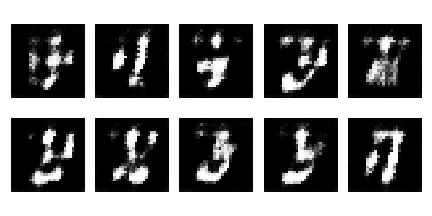

In [14]:
from IPython.display import Image
Image(open('/content/dcgan.gif','rb').read())

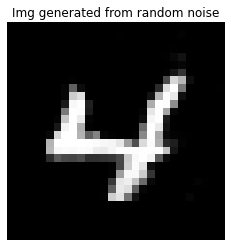

In [18]:
#from keras.models import load_model
#import numpy as np

#gen = load_model('generator.h5')

#genero un'immagine dal generatore con del rumore casuale
out = gen([np.random.normal(0, 1, size=[1, noise_dim]), np.array([4])])

plt.figure(3)
plt.title('Img generated from random noise')
plt.imshow(out.numpy().reshape(input_shape[0], input_shape[1]), cmap='gray')
plt.axis('off')
plt.show()